# Kernel CCA: ICD Method

Kernel matrices grow exponentially with the size of the data. There are immense storage and run-time constraints that arise when working with large datasets. The Incomplete Cholesky Decomposition (ICD) looks for a low rank approximation of the Cholesky decomposition of the kernel matrix. This reduces storage requirements from O(n^2) to O(nm), where n is the number of subjects (rows) and m is the rank of the kernel matrix. This also reduces the run-time from O(n^3) to O(nm^2).

In [35]:
import numpy as np
import sys
sys.path.append("../../..")

from mvlearn.embed.kcca import KCCA
from mvlearn.plotting.plot import crossviews_plot
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import warnings
import matplotlib.cbook
import time
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [2]:
def make_data(kernel, N):
    # # # Define two latent variables (number of samples x 1)
    latvar1 = np.random.randn(N,)
    latvar2 = np.random.randn(N,)
    
    # # # Define independent components for each dataset (number of observations x dataset dimensions)
    indep1 = np.random.randn(N, 4)
    indep2 = np.random.randn(N, 5)
    
    if kernel == "linear":
        x = 0.25*indep1 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2)).T
        y = 0.25*indep2 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2, latvar1)).T
        
        return [x,y]
    
    elif kernel == "poly":
        x = 0.25*indep1 + 0.75*np.vstack((latvar1**2, latvar2**2, latvar1**2, latvar2**2)).T
        y = 0.25*indep2 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2, latvar1)).T
        
        return [x,y]
    
    elif kernel == "gaussian":
        t = np.random.uniform(-np.pi, np.pi, N)
        e1 = np.random.normal(0, 0.05, (N,2))
        e2 = np.random.normal(0, 0.05, (N,2))
        
        x = np.zeros((N,2))
        x[:,0] = t
        x[:,1] = np.sin(3*t)
        x += e1
        
        y = np.zeros((N,2))
        y[:,0] = np.exp(t/4)*np.cos(2*t)
        y[:,1] = np.exp(t/4)*np.sin(2*t)
        y += e2
        
        return [x,y]

## Full Decomposition vs ICD on Sample Data

ICD is run on two views of data that each have two dimensions that are sinuisoidally related. The data has 100 samples and thus the fully decomposed kernel matrix would have dimensions (100, 100). Instead we implement ICD with a kernel matrix of rank 50 (mrank = 50).

In [7]:
np.random.seed(1)
Xsg = make_data('gaussian', 100)

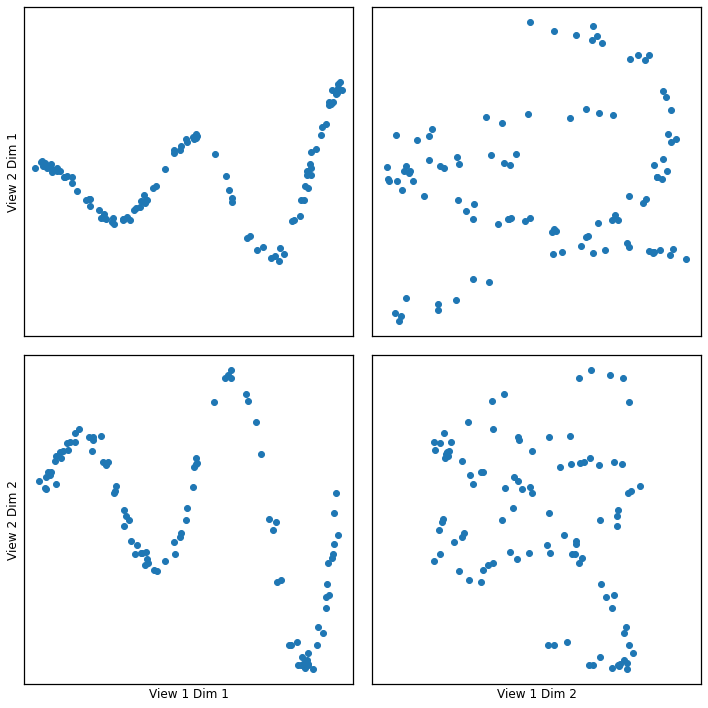

In [9]:
crossviews_plot(Xsg, ax_ticks=False, ax_labels=True, equal_axes=True)

### Full Decomposition

In [8]:
kcca_g = KCCA(ktype ="gaussian", n_components = 2, reg = 0.01)
kcca_g.fit(Xsg)
gausskcca = kcca_g.transform(Xsg)

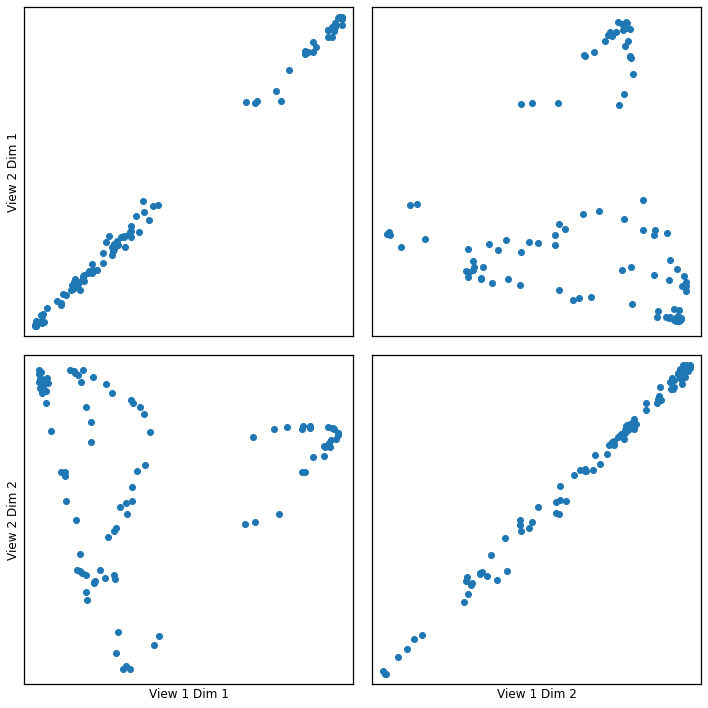

In [10]:
crossviews_plot(gausskcca, ax_ticks=False, ax_labels=True, equal_axes=True)

In [11]:
(gr1, _) = stats.pearsonr(gausskcca[0][:,0], gausskcca[1][:,0])
(gr2, _) = stats.pearsonr(gausskcca[0][:,1], gausskcca[1][:,1])

print("Below are the canonical correlation of the two components:")
print(gr1,gr2)

Below are the canonical correlation of the two components:
0.9988060118791638 0.9972876357732628


### ICD Decomposition

In [12]:
kcca_g_icd = KCCA(ktype = "gaussian", sigma = 1.0, n_components = 2, reg = 0.01, decomp = 'icd', mrank = 50)
icd_g = kcca_g_icd.fit_transform(Xsg)

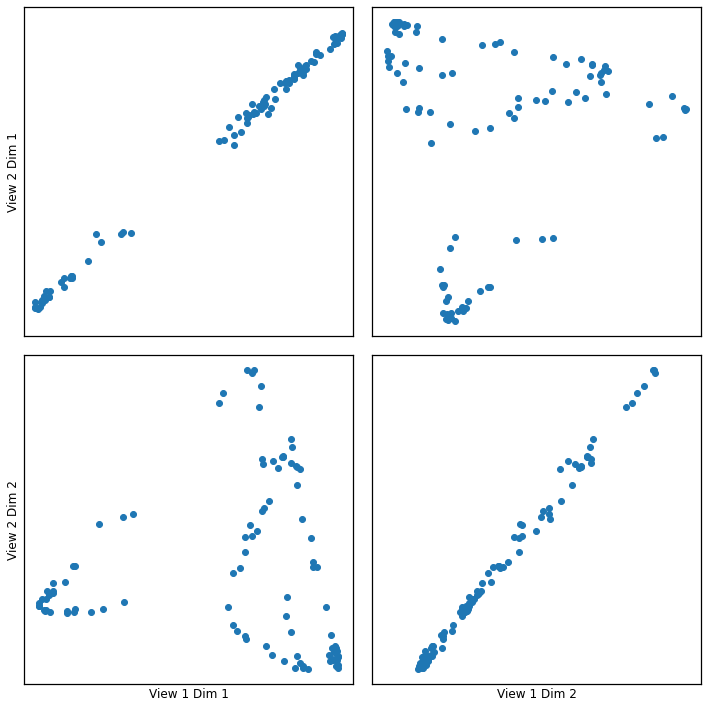

In [13]:
crossviews_plot(icd_g, ax_ticks=False, ax_labels=True, equal_axes=True)

In [15]:
(icdr1, _) = stats.pearsonr(icd_g[0][:,0], icd_g[1][:,0])
(icdr2, _) = stats.pearsonr(icd_g[0][:,1], icd_g[1][:,1])

print("Below are the canonical correlation of the two components:")
print(icdr1,icdr2)

Below are the canonical correlation of the two components:
0.998805983433145 0.997287542632157


The canonical correlations of full vs ICD (mrank=50) are very similar!

## ICD Kernel Rank vs. Canonical Correlation

We can observe the relationship between the ICD kernel rank and canonical correlation of the first canonical component.

In [32]:
can_corrs = []
rank = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

for i in rank:
    kcca_g_icd = KCCA(ktype = "gaussian", sigma = 1.0, n_components = 2, reg = 0.01, decomp = 'icd', mrank = i)
    icd_g = kcca_g_icd.fit_transform(Xsg)
    (icdr1, _) = stats.pearsonr(icd_g[0][:,0], icd_g[1][:,0])
    can_corrs.append(icdr1)

Text(0, 0.5, 'Canonical Correlation')

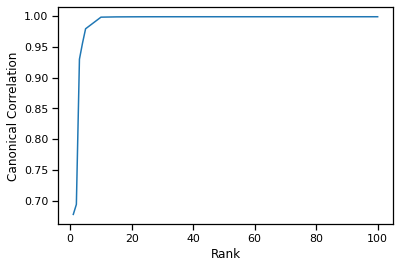

In [34]:
plt.plot(rank, can_corrs)
plt.xlabel('Rank')
plt.ylabel('Canonical Correlation')

We observe that around rank=10-15 we achieve the same canonical correlation as the fully decomposed kernel matrix (rank=100).

## ICD Kernel Rank vs Run-Time

We can observe the relationship between the ICD kernel rank and run-time to fit and transform the two views. We average the run-time of each rank over 5 trials.

In [38]:
run_time = []

for i in rank:
    run_time_sample = []
    for a in range(5):
        kcca_g_icd = KCCA(ktype = "gaussian", sigma = 1.0, n_components = 2, reg = 0.01, decomp = 'icd', mrank = i)
        start = time.time()
        icd_g = kcca_g_icd.fit_transform(Xsg)
        run_time_sample.append(time.time()-start)
    run_time.append(sum(run_time_sample) / len(run_time_sample))

Text(0, 0.5, 'Run-Time')

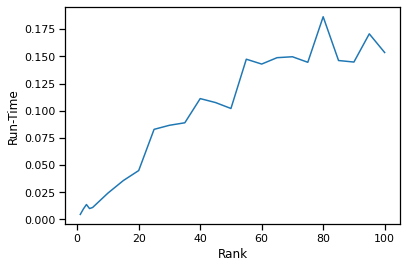

In [39]:
plt.plot(rank, run_time)
plt.xlabel('Rank')
plt.ylabel('Run-Time')

From the rank vs canonical correlation analysis in the previous section, we discovered that a rank of 10-15 will preserve the canonical correlation (accuracy). We can see that at a rank of 10-15, we can get an order of magnitude decrease in run-time compared to a rank of 100 (full decomposition).